In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchinfo import summary

5


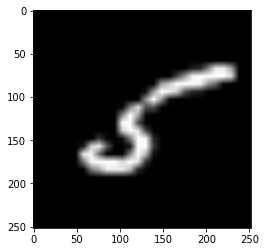

In [8]:
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
image, label = train_dataset[11]
print(label)
plt.imshow(image, cmap="gray")
a = transforms.Resize(252)(image)
plt.imshow(a, cmap="gray")

# Training Vanilla CNN for MNIST Data

In [11]:
#Hyper Parameters
batch_size = 128
learning_rate = 0.001
epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)])
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1014, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1, 1014)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} ')

Epoch [1/1], Step [100/469], Loss: 0.3138 
Epoch [1/1], Step [200/469], Loss: 0.2063 
Epoch [1/1], Step [300/469], Loss: 0.1137 
Epoch [1/1], Step [400/469], Loss: 0.1591 


In [15]:
def data_aug(img_tensor):
    aug = transforms.RandomResizedCrop(20, scale=(0.08,0.1))(img_tensor)
    aug = transforms.RandomHorizontalFlip(p=0.5)(aug)
    aug = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)(aug)
    #aug = transforms.RandomGrayscale(0.2)(aug)
    aug = transforms.GaussianBlur(kernel_size=23, sigma=0.5)(aug)
    aug = transforms.RandomSolarize(threshold=0.3,p=0.1)(aug)
    #aug = transforms.Normalize()(aug)
    return aug
    

N = 64
data = torch.rand(N,1,20,20)
data = data_aug(data)
print(data.shape)
conv1 = nn.Conv2d(1, 12, kernel_size=1)
conv2 = nn.Conv2d(12, 6, kernel_size=3)
max_pool = nn.MaxPool2d(2, 2)
x = conv1(data)
print(x.shape)
x = conv2(x)
print(x.shape)
x = max_pool(x)
print(x.shape)
x = x.view(-1,486)
fc1 = nn.Linear(486, 256)
x = fc1(x)
print(x.shape)
fc2 = nn.Linear(256, 128)
x = fc2(x)
print(x.shape)
fc3 = nn.Linear(128,10)
x = fc3(x)
print(x.shape)

torch.Size([64, 1, 20, 20])
torch.Size([64, 12, 20, 20])
torch.Size([64, 6, 18, 18])
torch.Size([64, 6, 9, 9])
torch.Size([64, 256])
torch.Size([64, 128])
torch.Size([64, 10])


## Testing Torch Augmentations

In [13]:
#Hyper Parameters
batch_size = 128
learning_rate = 0.001
epochs = 1

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)])
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN_augs(nn.Module):
    def __init__(self):
        super(CNN_augs, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(486, 256)
        self.fc2 = nn.Linear(256, 128)
        # change output channels to multiples of 2 --> maybe 16, 32??
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1,486)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def data_aug(self, img_tensor):
        aug = transforms.RandomResizedCrop(20, scale=(0.08,0.1))(img_tensor)
        aug = transforms.RandomHorizontalFlip(p=0.5)(aug)
        aug = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)(aug)
        #aug = transforms.RandomGrayscale(0.2)(aug)
        aug = transforms.GaussianBlur(kernel_size=23, sigma=0.5)(aug)
        aug = transforms.RandomSolarize(threshold=0.3,p=0.1)(aug)
        #aug = transforms.Normalize()(aug)
        return aug
    

model = CNN_augs().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        images = model.data_aug(images)
        labels = labels.to(device)

        outputs = model(images)
        # compute loss between two different data augs!
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} ')

Epoch [1/1], Step [100/469], Loss: 2.3023 
Epoch [1/1], Step [200/469], Loss: 2.2794 
Epoch [1/1], Step [300/469], Loss: 2.2823 
Epoch [1/1], Step [400/469], Loss: 2.2718 


In [6]:
model = CNN_augs().to(device=device)
summary(model, input_size=[(batch_size, 1, 20, 20)])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_augs                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 12, 20, 20]         24
├─Conv2d: 1-2                            [128, 6, 18, 18]          654
├─MaxPool2d: 1-3                         [128, 6, 9, 9]            --
├─Linear: 1-4                            [128, 256]                124,672
├─Linear: 1-5                            [128, 128]                32,896
├─Linear: 1-6                            [128, 10]                 1,290
Total params: 159,536
Trainable params: 159,536
Non-trainable params: 0
Total mult-adds (M): 48.69
Input size (MB): 0.20
Forward/backward pass size (MB): 7.31
Params size (MB): 0.64
Estimated Total Size (MB): 8.15

# Implementing VICReg

In [ ]:
#Hyper Parameters
batch_size = 128
learning_rate = 0.001
epochs = 1
#Dimension of the representations
D = 10

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)])
train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN_augs(nn.Module):
    def __init__(self):
        super(CNN_augs, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=1)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(486, 256)
        self.fc2 = nn.Linear(256, 128)
        # change output channels to multiples of 2 --> maybe 16, 32??
        self.fc3 = nn.Linear(128,D)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.view(-1,486)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def data_aug(self, img_tensor):
        aug = transforms.RandomResizedCrop(20, scale=(0.08,0.1))(img_tensor)
        aug = transforms.RandomHorizontalFlip(p=0.5)(aug)
        aug = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)(aug)
        #aug = transforms.RandomGrayscale(0.2)(aug)
        aug = transforms.GaussianBlur(kernel_size=23, sigma=0.5)(aug)
        aug = transforms.RandomSolarize(threshold=0.3,p=0.1)(aug)
        #aug = transforms.Normalize()(aug)
        return aug
    

model = CNN_augs().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # two randomly augmented versions of image
        image_i = model.data_aug(images)
        image_j = model.data_aug(images)

        labels = labels.to(device)
        #compute representations
        output_i = model(image_i)
        output_j = model(image_j)

        #invariance loss
        sim_loss = nn.MSELoss(image_i, image_j)

        #variance loss
        std_output_i = torch.sqrt(torch.var(output_i, dim=0) + 1e-04)
        std_output_j = torch.sqrt(torch.var(output_j, dim = 0) + 1e-04)
        sd_loss = torch.mean(F.relu(1-std_output_i)) + torch.mean(F.relu(1-std_output_j))

        #covariance loss
        output_i = output_i - torch.mean(output_i, dim=0)
        output_j = output_j - torch.mean(output_j, dim=0)
        cov_output_i = (torch.matmul(torch.transpose(output_i), output_i) / (batch_size -1))
        cov_output_j = (torch.matmul(torch.transpose(output_j), output_j) / (batch_size -1))
        #cov_loss = 


        # compute loss between two different data augs!
        loss = criterion(output_i, output_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f} ')

## Downstream tasks
- **Classification**
- Regression
- Simulate representation of the data
- Autoencoder --> anomaly detection